For this first deliverable, I need to develop this:
<br /> 1.- Apply scaling techniques
<br /> 2.- preprocess of data

In [1]:
# Since maybe I'll use my home computer instead of the colab, I'll list the install comands:

# =================================
# PLEASE ONLY RUN ONCE, THEN COMMENT
# THIS SECTION AGAIN.
# =================================

#%pip install numpy
#%pip install pandas
#%pip install tensorflow
#%pip install matplotlib
#%pip install scipy
#%pip install seaborn
#%pip install scikit-learn
#%pip install tensorflow

In [2]:
# All the imports come here
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, regularizers
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Normalization, Input, Conv2D, Dropout

In [3]:
# It's important to comment the import depending on the OS
# Windows PC
base_dir = r"./dataset/car parts"

# Mac OS
# base_dir = "/Users/alanpagzz/Codes/carssification_AI/dataset/car parts"

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = "/content/drive/MyDrive/Octavo Semestre/IA/car dataset/car parts"

In [4]:
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# I will ommit the test directory for now. I don't want to mix the test data with the training data

In [ ]:
# Time to preprocess the data

# SCALING
# First, scale pixels from 0-255 to 0-1, also augment my data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range = 10,
    width_shift_range = 0.2,
	height_shift_range = 0.2,
    #shear_range = 0.3,
	#zoom_range = 0.3,
	horizontal_flip = True
    )

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range = 10,
    width_shift_range = 0.2,
	height_shift_range = 0.2,
    #shear_range = 0.3,
	#zoom_range = 0.3,
	horizontal_flip = True
        )


# PREPROCESS
train_generator = train_datagen.flow_from_directory(
    train_dir,
    # My images are 254x254
    target_size=(150, 150),
    batch_size=8,
    class_mode="categorical",
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode="categorical"
)


Found 6917 images belonging to 40 classes.
Found 200 images belonging to 40 classes.


In [ ]:
# ResNet50
# Retrieved from documentation

with tf.device('/GPU:0'):
      # Cancer paper model
      customModel = tf.keras.models.Sequential([
        Input(shape=(150, 150, 3)),
        Conv2D(32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=2),
        Conv2D(64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=2),
        Conv2D(128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=2),
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(40, activation='softmax')
      ])

      ResNet50 = tf.keras.applications.ResNet50(
        input_shape=(150, 150, 3),
        include_top=False,
        weights="imagenet",
        classifier_activation="softmax",
        name="resnet50",
        pooling="average"
      )

  # This is my model
      model = tf.keras.models.Sequential([
        ResNet50,
        GlobalAveragePooling2D(),
        Dense(2048, activation = 'relu'),
        Dense(256, activation = 'relu'),
        Dense(40, activation = 'softmax')
  ])

model.summary()

model.layers[0].trainable = False

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,318,888 (108.03 MB)

 Trainable params: 28,265,768 (107.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
# Time to add a checkpoint

# I want it on the same spot on every device, It's easier

# Drive
# checkpoint_path = "/content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/cp-{epoch:02d}.weights.h5"

# Windows
checkpoint_path = os.path.join(r"./", "checkpoints", "cp-{epoch:02d}.weights.h5")

# Mac OS
# checkpoint_path = PUTSOMETHINGHERE

checkpoint = LambdaCallback(
    on_epoch_end=lambda epoch, logs: model.save_weights(checkpoint_path.format(epoch=epoch)) if (epoch + 1) % 5 == 0 else None
)

In [8]:
def compile_model_simple(model):
    # CATEGORICAL CROSS SENTROPY
    model.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

def train_model_simple(model, scaled_train_images):
  # The cancer model paper mentions that it reaches a good level of accuracy on
  # epoch 20ish (The graph is up to epoch 25)
    history = model.fit(scaled_train_images, validation_data=valid_generator,
                        epochs = 25,  callbacks=[checkpoint]
                        )
    return history

In [9]:
compile_model_simple(model)
history = train_model_simple(model, train_generator)

C:\Users\patom\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 446s 500ms/step - accuracy: 0.0395 - loss: 3.6857 - val_accuracy: 0.0750 - val_loss: 3.6022
Epoch 2/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 543s 628ms/step - accuracy: 0.0880 - loss: 3.3808 - val_accuracy: 0.0950 - val_loss: 3.3693
Epoch 3/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 461s 532ms/step - accuracy: 0.1227 - loss: 3.2184 - val_accuracy: 0.1300 - val_loss: 3.2936
Epoch 4/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 460s 532ms/step - accuracy: 0.1304 - loss: 3.1713 - val_accuracy: 0.1450 - val_loss: 3.2137
Epoch 5/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 470s 543ms/step - accuracy: 0.1414 - loss: 3.1012 - val_accuracy: 0.1300 - val_loss: 3.2784
Epoch 6/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 470s 543ms/step - accuracy: 0.1499 - loss: 3.0754 - val_accuracy: 0.1050 - val_loss: 3.1859
Epoch 7/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 470s 543ms/step - accuracy: 0.1680 - loss: 3.0041 - val_accuracy: 0.1650 - val_loss: 3.1292
Epoch 8/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 502s 580ms/step - accuracy: 0.1786 -

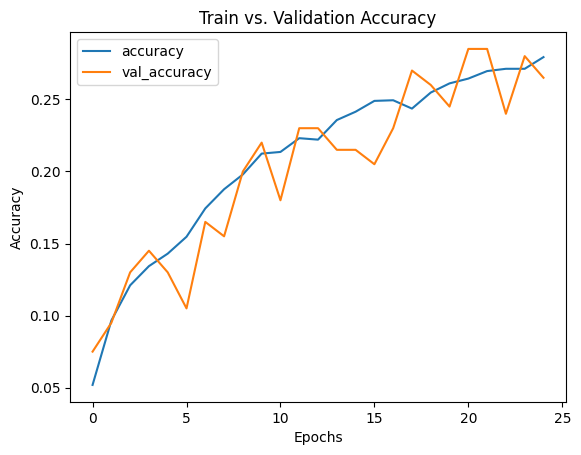

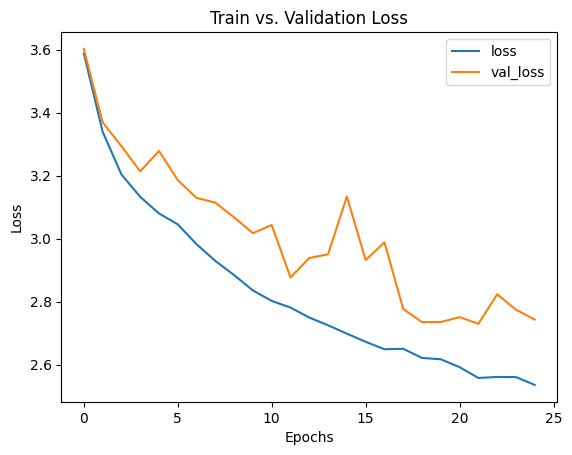

In [10]:
frame = pd.DataFrame(history.history)
acc_plot = frame.plot(y=["accuracy", "val_accuracy"], title="Train vs. Validation Accuracy", legend=True)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")
plt.show()

loss_plot = frame.plot(y=["loss", "val_loss"], title="Train vs. Validation Loss", legend=True)
loss_plot.set(xlabel="Epochs", ylabel="Loss")
plt.show()

In [12]:
# Get true classes and predicted classes for the validation set
true_classes = valid_generator.classes

# Predict probabilities for the validation set
valid_generator.reset()
val_pred_probs = model.predict(valid_generator, verbose=1)
val_pred_classes = np.argmax(val_pred_probs, axis=1)

precision = precision_score(true_classes, val_pred_classes, average='macro')
recall = recall_score(true_classes, val_pred_classes, average='macro')
f1 = f1_score(true_classes, val_pred_classes, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 628ms/step
Precision: 0.0163
Recall: 0.0200
F1 Score: 0.0170


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
